# Think Gaussian Shells with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = \log(e^{f(x,c_1,r_1,w_1)} + e^{f(x,c_2,r_2,w_2)}) $

where $f(x,c,r,w) = -\frac{1}{2 w^2}(|x - c| - r)^2 - \log(\sqrt(2 \pi w^2))$

and

$P(x) = \mathcal{U}[x \mid -6, 6 \pi]$.

## Overview

We'll cover the following topics:

1. How to handle thin curving degeneracies and multimodal behaviour with JAXNS.
2. How to use the `prior_chain` outside the nested sampler, e.g. to sample/plot.
3. How to brute-force compute the evidence for comparison.

In [1]:

from jaxns import NestedSampler
from jaxns import PriorChain, UniformPrior
from jaxns import summary, analytic_log_evidence
from jaxns.internals.maps import prepare_func_args
from jaxns import plot_cornerplot, plot_diagnostics
from jax import random, jit, vmap
from jax import numpy as jnp
import pylab as plt

In [2]:
def log_likelihood(theta, **kwargs):
    def log_circ(theta, c, r, w):
        return -0.5*(jnp.linalg.norm(theta - c) - r)**2/w**2 - jnp.log(jnp.sqrt(2*jnp.pi*w**2))
    w1=w2=jnp.array(0.1)
    r1=r2=jnp.array(2.)
    c1 = jnp.array([0., -3.])
    c2 = jnp.array([0., 3.])
    return jnp.logaddexp(log_circ(theta, c1,r1,w1) , log_circ(theta,c2,r2,w2))


with PriorChain() as prior_chain:
    UniformPrior('theta', low=-6.*jnp.ones(2), high=6.*jnp.ones(2))

log_Z_true = analytic_log_evidence(prior_chain=prior_chain, log_likelihood=log_likelihood, S=250)
print(f"True log(Z)={log_Z_true}")

WARNING[2022-04-06 18:15:44,131]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3035: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
WARNING[2022-04-06 18:15:44,214]: Function log_likelihood has **varkw parameter (kwargs), and is being dropped.


True log(Z)=-1.7456417083740234


WARNING[2022-04-06 18:15:44,669]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
WARNING[2022-04-06 18:15:45,033]: Function log_likelihood has **varkw parameter (kwargs), and is being dropped.


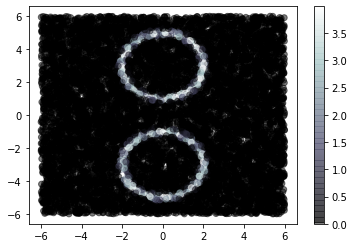

In [3]:
# To use the prior_chain to sample from, e.g. for plotting, we should first build it. This typically gets done inside the nested sampler, and if not should be done manually.
prior_chain.build()

theta = vmap(lambda key: prior_chain(prior_chain.sample_U_flat(key)))(
    random.split(random.PRNGKey(0), 10000))
# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(lambda theta: prepare_func_args(log_likelihood)(**theta))(theta)
sc = plt.scatter(theta['theta'][:, 0], theta['theta'][:, 1], c=jnp.exp(lik), cmap='bone', alpha=0.5)
plt.colorbar(sc)
plt.show()

In [4]:
# Create the nested sampler class. In this case without any tuning.
ns = NestedSampler(log_likelihood, prior_chain)
# We jit-compile
ns = jit(ns)
# We run, with any parameters desired. In this case, without any tuning.
results = ns(random.PRNGKey(4525325))


WARNING[2022-04-06 18:15:45,556]: Increasing max_samples (100000) by 200 to evenly divide samples_per_step
WARNING[2022-04-06 18:15:45,568]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3035: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncate

In [5]:
# We can use the summary utility to display results
summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 164492
# samples: 1400
# likelihood evals / sample: 117.5
--------
logZ=-1.86 +- 0.15
H=2.8
ESS=154
--------
theta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
theta[0]: -0.1 +- 1.5 | -1.9 / -0.2 / 1.9 | 0.3 | -1.4
theta[1]: -1.3 +- 2.9 | -4.6 / -1.8 / 3.0 | -4.9 | -4.4
--------


'--------\nTermination Conditions:\nSmall remaining evidence\n--------\n# likelihood evals: 164492\n# samples: 1400\n# likelihood evals / sample: 117.5\n--------\nlogZ=-1.86 +- 0.15\nH=2.8\nESS=154\n--------\ntheta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\ntheta[0]: -0.1 +- 1.5 | -1.9 / -0.2 / 1.9 | 0.3 | -1.4\ntheta[1]: -1.3 +- 2.9 | -4.6 / -1.8 / 3.0 | -4.9 | -4.4\n--------'

WARNING[2022-04-06 18:15:58,794]: No handles with labels found to put in legend.
WARNING[2022-04-06 18:15:59,009]: No handles with labels found to put in legend.


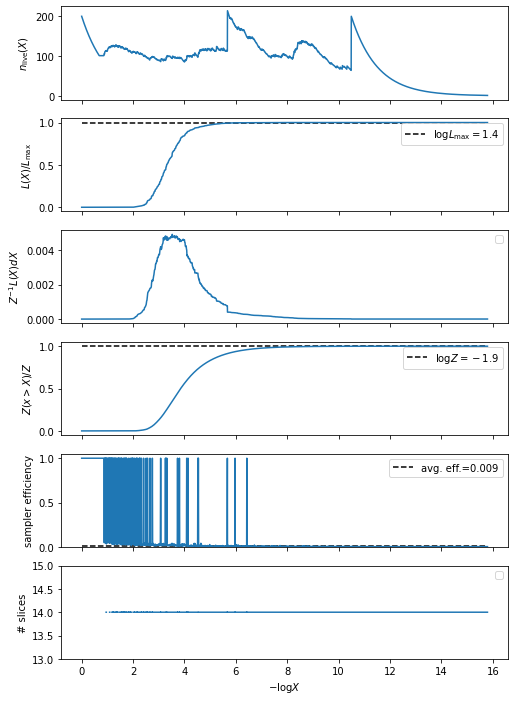

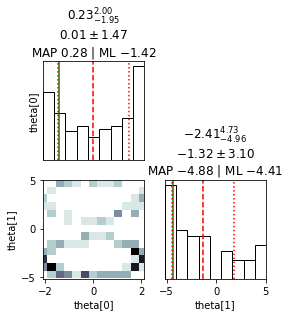

In [6]:
# We plot useful diagnostics and a distribution cornerplot
plot_diagnostics(results)
plot_cornerplot(results)